Задача - multi-label классификация - освежить память что это значит (https://scikit-learn.org/stable/modules/multiclass.html).

Тартеты: 14 последних колонок - df.iloc[:,-14:]

Метрика: Micro averaged F1. Хорошо бы оценивать качество с помощью кросс-валидации.

- Построить baseline с использованием линейной модели из scikit-learn


- Чистый Tensorflow

Построить линейную модель для решения этой задачи. Можно взять существующий код из блокнота Tensorflow examples 1.ipynb и переделать.


- Keras

Сделать тоже самое как и в Tensorflow но использовав чистый Keras

Добавить слоёв и нелинейностей, сравнить качество моделей


In [1]:
!pip install --upgrade pandas
!pip install --upgrade scikit-learn
!pip install --upgrade inflect
!pip install --upgrade seaborn
!pip install --upgrade pprint
!pip install --upgrade tensorflow
#!pip install --upgrade contractions
#!pip install --upgrade wordcloud
#!pip install --upgrade umap-learn
#!pip install --upgrade gensim
#!pip install --upgrade pyldavis

Requirement already up-to-date: pandas in c:\anaconda\lib\site-packages (0.24.0)
Requirement already up-to-date: scikit-learn in c:\anaconda\lib\site-packages (0.20.2)
Requirement already up-to-date: inflect in c:\anaconda\lib\site-packages (2.1.0)
Requirement already up-to-date: seaborn in c:\anaconda\lib\site-packages (0.9.0)
Requirement already up-to-date: pprint in c:\anaconda\lib\site-packages (0.1)
Requirement already up-to-date: tensorflow in c:\anaconda\lib\site-packages (1.12.0)


In [2]:
#common libs
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns

import re
import string
import inflect
import itertools
from pprint import pprint
from tqdm import tqdm
from time import time
from itertools import compress
from collections import Counter
#import glob
#import contractions
#from wordcloud import WordCloud
#import umap
#import unicodedata
#from bs4 import BeautifulSoup

#import time

#from scipy import interp
sns.set(font_scale=1.3)

seed = 321

%matplotlib inline

In [3]:
#sklearn libs
from sklearn.preprocessing import label_binarize,MultiLabelBinarizer,StandardScaler
from sklearn.pipeline import make_pipeline,Pipeline

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.cluster import KMeans,DBSCAN

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split 
from sklearn.model_selection import KFold,RandomizedSearchCV, cross_val_score

from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import confusion_matrix, classification_report,f1_score, make_scorer
from sklearn.metrics import homogeneity_score,completeness_score, v_measure_score
from sklearn.metrics import adjusted_rand_score,adjusted_mutual_info_score,silhouette_score
from sklearn.manifold import TSNE

from sklearn.decomposition import TruncatedSVD

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [4]:
import tensorflow as tf

read first ten row to understand, how to parse data.

In [5]:
df = pd.read_csv('data/multilabel_dataset.csv', nrows = 15)

In [6]:
df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,0,0,1,1,0,0,0,1,1,0
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,0,0,0,0,0,0,0,0,0,0
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,0,0,0,0,0,0,0,1,1,0
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,0,0,0,0,0,0,0,0,0,0
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,1,1,0,0,0,0,0,0,0,0
5,0.003286,-0.023601,-0.023104,-0.064171,-0.017719,-0.113510,-0.035212,-0.077675,-0.024348,-0.012458,...,0,0,0,0,0,1,1,1,1,0
6,0.076606,-0.025478,0.072419,-0.065383,0.123539,0.120130,0.102248,0.008324,0.094147,-0.014666,...,0,0,0,0,0,0,0,1,1,0
7,-0.106801,-0.069277,-0.132254,-0.099246,-0.188413,-0.110359,-0.155120,-0.168094,-0.182473,0.023208,...,0,0,0,0,0,0,0,1,1,0
8,0.177650,0.136159,0.153211,0.190312,0.158541,0.219521,0.079914,0.232238,0.127932,0.089142,...,0,0,0,0,0,0,0,1,1,0
9,0.122075,-0.055828,-0.034775,-0.039235,0.075027,0.087308,0.088062,0.122385,0.091848,-0.099132,...,0,0,0,0,0,0,0,1,1,0


In [7]:
df = pd.read_csv('data/multilabel_dataset.csv', sep = ',', header = 0, decimal = '.')

- types of features.+
- Count Na.+
- Values distribution.+
- train test split or Separate target from whole dataset.+
- pipeline.
- eval score function.

- shape, types of features (+ value counts).

In [8]:
df.shape

(2417, 117)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2417 entries, 0 to 2416
Columns: 117 entries, feature_0 to target_13
dtypes: float64(103), int64(14)
memory usage: 2.2 MB


In [10]:
df.head(n=7)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,0,0,1,1,0,0,0,1,1,0
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,0,0,0,0,0,0,0,0,0,0
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,0,0,0,0,0,0,0,1,1,0
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,0,0,0,0,0,0,0,0,0,0
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,1,1,0,0,0,0,0,0,0,0
5,0.003286,-0.023601,-0.023104,-0.064171,-0.017719,-0.113510,-0.035212,-0.077675,-0.024348,-0.012458,...,0,0,0,0,0,1,1,1,1,0
6,0.076606,-0.025478,0.072419,-0.065383,0.123539,0.120130,0.102248,0.008324,0.094147,-0.014666,...,0,0,0,0,0,0,0,1,1,0


In [11]:
df.tail(n=7)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13
2410,0.061517,-0.051652,-0.058484,-0.181543,0.015579,-0.058696,0.043339,0.065145,0.044191,-0.030596,...,0,0,0,0,0,0,0,1,1,0
2411,0.032532,-0.015245,0.029789,0.046352,0.095598,0.005617,0.043168,0.006583,-0.033460,-0.022285,...,0,1,1,1,0,0,1,1,1,0
2412,-0.119784,0.001259,-0.123645,-0.015513,-0.059683,0.091032,-0.043302,0.229219,-0.071498,0.182709,...,0,0,0,0,0,0,0,0,0,0
2413,0.085327,0.058590,0.085268,-0.020897,0.068972,0.030125,0.078056,0.011346,0.052618,0.066093,...,0,0,0,0,0,0,0,1,1,0
2414,0.082526,-0.095571,-0.022019,-0.046793,-0.038360,0.041084,0.056509,0.011749,-0.029657,-0.012198,...,0,1,1,1,0,0,0,1,1,0
2415,-0.130830,0.008868,-0.009457,-0.058930,-0.041224,0.042269,0.117717,0.037388,-0.085563,0.136649,...,0,0,0,0,0,0,0,1,1,0
2416,-0.171578,-0.066536,0.168206,0.246831,0.079555,0.016528,-0.088908,-0.212926,-0.280230,-0.187064,...,0,0,0,0,0,0,0,1,1,0


In [12]:
df.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13
count,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,...,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000
mean,0.001173,-0.000436,-0.000257,0.000265,0.001228,0.000475,0.001107,0.000420,0.001076,-0.000009,...,0.298717,0.247000,0.177079,0.198593,0.073645,0.104675,0.119570,0.751345,0.744311,0.014067
std,0.097411,0.097885,0.097746,0.096969,0.096909,0.097306,0.097170,0.096803,0.096326,0.096805,...,0.457790,0.431356,0.381815,0.399024,0.261246,0.306198,0.324525,0.432323,0.436338,0.117792
min,-0.371146,-0.472632,-0.339195,-0.467945,-0.367044,-0.509447,-0.319928,-0.594498,-0.369712,-0.767128,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.053655,-0.058734,-0.057526,-0.057149,-0.058461,-0.060212,-0.058445,-0.062849,-0.063472,-0.065010,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.003649,-0.003513,0.002892,-0.000153,0.005565,0.000321,0.006179,0.001436,0.003515,0.002432,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,0.057299,0.048047,0.061007,0.054522,0.066286,0.059908,0.068892,0.061418,0.064958,0.063096,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,0.520272,0.614114,0.353241,0.568960,0.307649,0.336971,0.351401,0.454591,0.419852,0.420876,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Данные уже отскейлены.

- Count Na.

In [13]:
#pprint()
list_NAs = df.isna().sum()

In [14]:
list_NAs[list_NAs != 0]

Series([], dtype: int64)

- Values distribution.

In [15]:
for i, col in enumerate(df.columns[:-1]):
    print(df[col].value_counts())

 0.010874    2
 0.034992    2
 0.039202    2
-0.008702    2
-0.039346    2
-0.070084    1
 0.210828    1
-0.131098    1
-0.025655    1
-0.021963    1
 0.026088    1
-0.043508    1
 0.119198    1
 0.388550    1
 0.060083    1
 0.072999    1
 0.092940    1
-0.044110    1
-0.083235    1
 0.057455    1
-0.059573    1
-0.028407    1
 0.098179    1
 0.025312    1
 0.049739    1
 0.011376    1
-0.059139    1
-0.028324    1
-0.059665    1
 0.013331    1
            ..
 0.125229    1
-0.016552    1
-0.016316    1
-0.013974    1
 0.170463    1
 0.059123    1
-0.154369    1
 0.014766    1
-0.001680    1
-0.036187    1
 0.068102    1
 0.246440    1
 0.180837    1
 0.065442    1
-0.077342    1
 0.057299    1
 0.140251    1
 0.042090    1
-0.116600    1
 0.100084    1
 0.029774    1
 0.007968    1
-0.224449    1
-0.111997    1
-0.022782    1
 0.029016    1
 0.051795    1
-0.066044    1
-0.015922    1
-0.314341    1
Name: feature_0, Length: 2412, dtype: int64
-0.072304    2
 0.090400    2
 0.018429  

Name: feature_8, Length: 2406, dtype: int64
 0.088529    2
 0.079734    2
 0.099604    1
-0.206627    1
 0.071719    1
 0.044235    1
-0.044157    1
 0.093367    1
-0.047237    1
 0.033155    1
 0.111551    1
-0.073359    1
 0.075501    1
-0.088856    1
-0.106833    1
-0.023714    1
-0.020312    1
 0.096871    1
-0.055523    1
-0.105404    1
 0.061552    1
 0.038144    1
-0.046110    1
-0.082239    1
-0.074545    1
 0.027502    1
 0.132970    1
 0.030996    1
-0.150812    1
-0.198749    1
            ..
 0.032721    1
 0.054718    1
-0.034385    1
 0.106936    1
 0.068922    1
 0.012681    1
-0.105667    1
-0.085767    1
-0.081296    1
-0.069254    1
-0.106474    1
 0.058752    1
 0.126128    1
 0.142919    1
-0.193276    1
-0.070911    1
 0.006699    1
 0.030870    1
-0.027706    1
-0.101405    1
-0.017510    1
-0.114967    1
-0.005615    1
-0.029069    1
 0.010393    1
 0.102686    1
-0.070355    1
 0.109637    1
-0.226714    1
 0.008012    1
Name: feature_9, Length: 2415, dtype: int

Name: feature_17, Length: 2409, dtype: int64
 0.095860    2
 0.135140    2
 0.024469    2
-0.107806    2
-0.083831    2
-0.029062    2
-0.040405    2
 0.105414    1
 0.040587    1
-0.158365    1
 0.171611    1
-0.010877    1
 0.107199    1
-0.126920    1
 0.114289    1
-0.028508    1
-0.020745    1
-0.015571    1
-0.088066    1
-0.056013    1
 0.007588    1
-0.024840    1
 0.032961    1
 0.048907    1
 0.057863    1
-0.030582    1
 0.194862    1
-0.095646    1
 0.011109    1
 0.144622    1
            ..
-0.023729    1
 0.062088    1
 0.027272    1
-0.162052    1
 0.044791    1
-0.044154    1
 0.009175    1
-0.091895    1
 0.084206    1
 0.121937    1
-0.012196    1
 0.103976    1
 0.008760    1
-0.070545    1
 0.094661    1
 0.102686    1
-0.064263    1
-0.166981    1
-0.009519    1
-0.005615    1
 0.050618    1
 0.073220    1
 0.126232    1
-0.003549    1
-0.018241    1
-0.089086    1
-0.159276    1
-0.053931    1
 0.055833    1
-0.001411    1
Name: feature_18, Length: 2410, dtype: i

Name: feature_26, Length: 2411, dtype: int64
 0.103423    2
 0.082236    2
 0.060966    2
 0.089864    2
-0.021779    2
-0.094854    2
 0.102224    2
 0.140587    1
 0.089789    1
 0.125080    1
-0.012808    1
-0.082567    1
 0.114020    1
-0.094182    1
 0.116030    1
-0.334658    1
-0.090896    1
 0.028387    1
-0.083039    1
-0.032462    1
-0.083050    1
-0.032745    1
-0.031545    1
-0.031912    1
 0.065042    1
-0.000081    1
 0.113053    1
 0.007200    1
 0.221738    1
 0.080091    1
            ..
 0.110541    1
 0.092475    1
 0.044850    1
 0.050426    1
 0.109802    1
-0.080607    1
 0.090644    1
 0.081231    1
 0.068875    1
-0.084852    1
-0.034051    1
 0.036137    1
 0.093583    1
-0.032692    1
-0.013539    1
-0.036896    1
 0.045907    1
-0.022782    1
-0.021201    1
-0.073147    1
-0.004664    1
 0.050861    1
 0.089883    1
-0.090659    1
 0.070263    1
 0.087332    1
-0.234043    1
-0.082066    1
 0.097943    1
-0.026497    1
Name: feature_27, Length: 2410, dtype: i

Name: feature_35, Length: 2410, dtype: int64
 0.011860    2
-0.054068    2
-0.016251    2
 0.109108    2
-0.116831    2
 0.023973    1
 0.158172    1
-0.026922    1
 0.043750    1
 0.097793    1
-0.155770    1
-0.125480    1
 0.055988    1
 0.030582    1
-0.020736    1
 0.002965    1
 0.034611    1
-0.194969    1
 0.063024    1
-0.038144    1
 0.094998    1
-0.003723    1
-0.087231    1
 0.080893    1
 0.181607    1
-0.149443    1
 0.074931    1
 0.112126    1
-0.070315    1
 0.009253    1
            ..
 0.009403    1
-0.292854    1
-0.058938    1
 0.048536    1
-0.178665    1
 0.145173    1
 0.146660    1
 0.100923    1
 0.011381    1
-0.073602    1
-0.135649    1
-0.055362    1
 0.144872    1
 0.040967    1
 0.179243    1
-0.068672    1
-0.099985    1
 0.011111    1
-0.156911    1
-0.081392    1
 0.060658    1
-0.087663    1
 0.175715    1
 0.051513    1
 0.007344    1
-0.125642    1
 0.063594    1
 0.084395    1
 0.026256    1
-0.140625    1
Name: feature_36, Length: 2412, dtype: i

Name: feature_44, Length: 2409, dtype: int64
 0.062946    2
-0.042140    2
-0.107781    2
-0.051698    1
-0.143395    1
-0.109512    1
-0.121066    1
 0.068361    1
 0.132099    1
 0.032115    1
 0.128384    1
 0.044312    1
 0.048671    1
 0.211361    1
 0.240686    1
-0.010253    1
-0.049981    1
 0.080764    1
-0.046411    1
-0.060083    1
 0.199947    1
-0.028820    1
 0.099139    1
 0.043968    1
 0.016633    1
-0.103066    1
-0.039938    1
 0.145475    1
 0.207164    1
-0.082959    1
            ..
-0.083728    1
-0.040773    1
-0.038246    1
-0.077813    1
-0.012287    1
-0.023062    1
 0.025260    1
 0.041073    1
 0.114928    1
 0.094142    1
 0.023102    1
 0.125517    1
-0.094155    1
-0.083484    1
 0.021612    1
-0.027011    1
 0.007958    1
-0.027278    1
 0.040019    1
 0.029255    1
 0.123207    1
-0.060566    1
-0.062592    1
-0.027579    1
 0.000264    1
-0.041996    1
 0.039958    1
 0.073006    1
 0.201614    1
 0.182265    1
Name: feature_45, Length: 2414, dtype: i

Name: feature_53, Length: 2409, dtype: int64
-0.014611    2
-0.070186    2
-0.091538    2
-0.070997    2
 0.078834    2
-0.093336    2
 0.008576    2
-0.109391    2
-0.099860    2
-0.030848    2
-0.051245    1
 0.087547    1
 0.349525    1
 0.075040    1
-0.164755    1
-0.026576    1
-0.085069    1
 0.045145    1
-0.008527    1
-0.121480    1
 0.051258    1
-0.038541    1
-0.021509    1
 0.146516    1
 0.007427    1
 0.029942    1
 0.174550    1
 0.060667    1
-0.074011    1
 0.025771    1
            ..
-0.005407    1
-0.094295    1
 0.094798    1
 0.074075    1
-0.073806    1
-0.039276    1
 0.050966    1
 0.067034    1
 0.003360    1
 0.083727    1
-0.082122    1
 0.109314    1
-0.070812    1
 0.001309    1
 0.022344    1
-0.029852    1
-0.017023    1
 0.184485    1
 0.040583    1
-0.028427    1
-0.116935    1
 0.020510    1
-0.030097    1
-0.004023    1
-0.093006    1
 0.066044    1
-0.064107    1
 0.026586    1
 0.132734    1
-0.062500    1
Name: feature_54, Length: 2407, dtype: i

Name: feature_62, Length: 2407, dtype: int64
-0.020360    2
-0.032941    2
-0.002117    2
-0.003750    2
 0.027889    2
 0.131862    2
-0.068407    2
-0.107812    2
-0.067560    2
 0.040801    2
 0.046836    2
-0.155095    2
 0.003039    2
-0.033397    2
 0.032688    2
-0.056535    2
-0.012056    1
-0.106852    1
-0.007903    1
 0.056566    1
 0.087550    1
 0.105379    1
-0.097746    1
-0.051800    1
-0.214699    1
 0.057575    1
-0.034539    1
 0.057862    1
 0.028807    1
-0.132474    1
            ..
-0.016213    1
 0.200829    1
-0.070232    1
-0.014648    1
-0.136607    1
-0.037742    1
 0.093284    1
 0.107077    1
 0.020932    1
-0.049207    1
-0.025952    1
-0.016937    1
 0.061587    1
-0.014075    1
 0.318079    1
 0.087828    1
 0.229411    1
 0.087946    1
 0.004269    1
 0.135386    1
 0.069686    1
-0.069673    1
-0.147401    1
-0.154083    1
 0.006173    1
 0.170828    1
-0.127896    1
-0.073204    1
-0.038666    1
-0.036478    1
Name: feature_63, Length: 2401, dtype: i

Name: feature_71, Length: 2408, dtype: int64
 0.081154    2
-0.004833    2
 0.114705    2
 0.121306    2
-0.011552    2
-0.014769    2
-0.021149    2
-0.062189    2
 0.119989    1
-0.008104    1
 0.119198    1
-0.203684    1
 0.209105    1
 0.133152    1
-0.007706    1
 0.023224    1
-0.046029    1
-0.037113    1
 0.102252    1
-0.095001    1
 0.065210    1
 0.030231    1
-0.026684    1
 0.115397    1
 0.041108    1
 0.067721    1
 0.025557    1
-0.069647    1
 0.035025    1
 0.026789    1
            ..
 0.100834    1
 0.044097    1
 0.024881    1
-0.120032    1
-0.015869    1
 0.017579    1
 0.063659    1
 0.075484    1
-0.060398    1
-0.037384    1
-0.018306    1
 0.066037    1
 0.076299    1
 0.106528    1
-0.023025    1
 0.116922    1
-0.108529    1
 0.011152    1
 0.082659    1
 0.049682    1
 0.090818    1
 0.139486    1
-0.044246    1
-0.036783    1
-0.019466    1
 0.006548    1
 0.195260    1
-0.075313    1
-0.011533    1
 0.032023    1
Name: feature_72, Length: 2409, dtype: i

Name: feature_80, Length: 2404, dtype: int64
-0.041567    2
-0.035771    2
 0.027453    2
-0.066616    2
-0.034601    2
 0.228410    2
-0.045737    2
-0.049664    2
-0.027792    2
 0.118750    1
 0.167676    1
-0.046659    1
-0.053551    1
-0.033813    1
-0.014117    1
 0.120086    1
-0.040781    1
-0.097238    1
 0.008086    1
 0.006137    1
 0.020311    1
-0.042139    1
-0.024562    1
-0.029942    1
-0.043684    1
-0.085907    1
 0.061188    1
-0.053812    1
-0.092414    1
-0.062932    1
            ..
-0.054718    1
 0.025629    1
 0.097538    1
 0.037913    1
-0.040232    1
-0.037893    1
-0.093506    1
 0.080582    1
 0.122543    1
 0.127332    1
-0.046571    1
 0.014764    1
-0.052369    1
-0.055265    1
-0.096832    1
-0.019358    1
-0.042956    1
-0.130813    1
 0.009406    1
-0.058834    1
-0.032559    1
 0.049352    1
 0.016669    1
-0.054878    1
-0.038872    1
-0.024797    1
-0.067478    1
 0.146935    1
-0.036015    1
-0.060777    1
Name: feature_81, Length: 2408, dtype: i

Name: feature_89, Length: 2408, dtype: int64
-0.030637    2
-0.017964    2
-0.074292    2
-0.033892    2
 0.029235    2
-0.044609    2
 0.000137    2
-0.068818    2
-0.041404    2
-0.036266    2
 0.076490    2
 0.101637    1
-0.032798    1
 0.056310    1
 0.037302    1
-0.072076    1
-0.072904    1
-0.029891    1
 0.015756    1
-0.069477    1
 0.227970    1
-0.039562    1
-0.069836    1
-0.001296    1
-0.026466    1
-0.092039    1
 0.034866    1
-0.048709    1
-0.007914    1
-0.108045    1
            ..
-0.031451    1
-0.086956    1
-0.071001    1
-0.039276    1
-0.089958    1
-0.030600    1
-0.050468    1
 0.098086    1
-0.041342    1
-0.066760    1
-0.084854    1
 0.037075    1
-0.020525    1
-0.070427    1
 0.013855    1
-0.029696    1
-0.035223    1
-0.111610    1
-0.019972    1
 0.046841    1
 0.006831    1
 0.013445    1
-0.037843    1
-0.056567    1
 0.056784    1
-0.073513    1
-0.054302    1
 0.231225    1
 0.031376    1
 0.286537    1
Name: feature_90, Length: 2406, dtype: i

Name: feature_98, Length: 2400, dtype: int64
-0.062847    2
-0.067583    2
 0.017150    2
-0.070214    2
-0.027554    2
-0.051664    2
-0.031969    2
-0.032225    2
-0.080606    2
-0.042350    2
-0.065826    2
-0.056582    2
-0.037331    2
-0.062239    2
-0.071898    2
-0.081925    2
-0.075395    1
-0.126761    1
-0.084382    1
-0.097427    1
-0.071536    1
 0.114705    1
 0.129151    1
 0.347594    1
-0.076595    1
-0.029705    1
 0.113518    1
-0.045929    1
-0.030145    1
-0.036688    1
            ..
-0.055640    1
-0.064839    1
-0.040271    1
-0.083243    1
-0.043256    1
-0.106958    1
-0.019603    1
 0.052984    1
-0.017343    1
-0.032155    1
-0.064982    1
 0.021714    1
 0.188994    1
 0.034116    1
-0.065767    1
 0.104227    1
-0.081013    1
-0.064379    1
 0.005105    1
-0.056551    1
-0.049251    1
 0.066159    1
 0.258583    1
 0.034998    1
 0.342444    1
-0.086708    1
 0.090719    1
-0.033303    1
 0.037129    1
-0.121554    1
Name: feature_99, Length: 2401, dtype: i

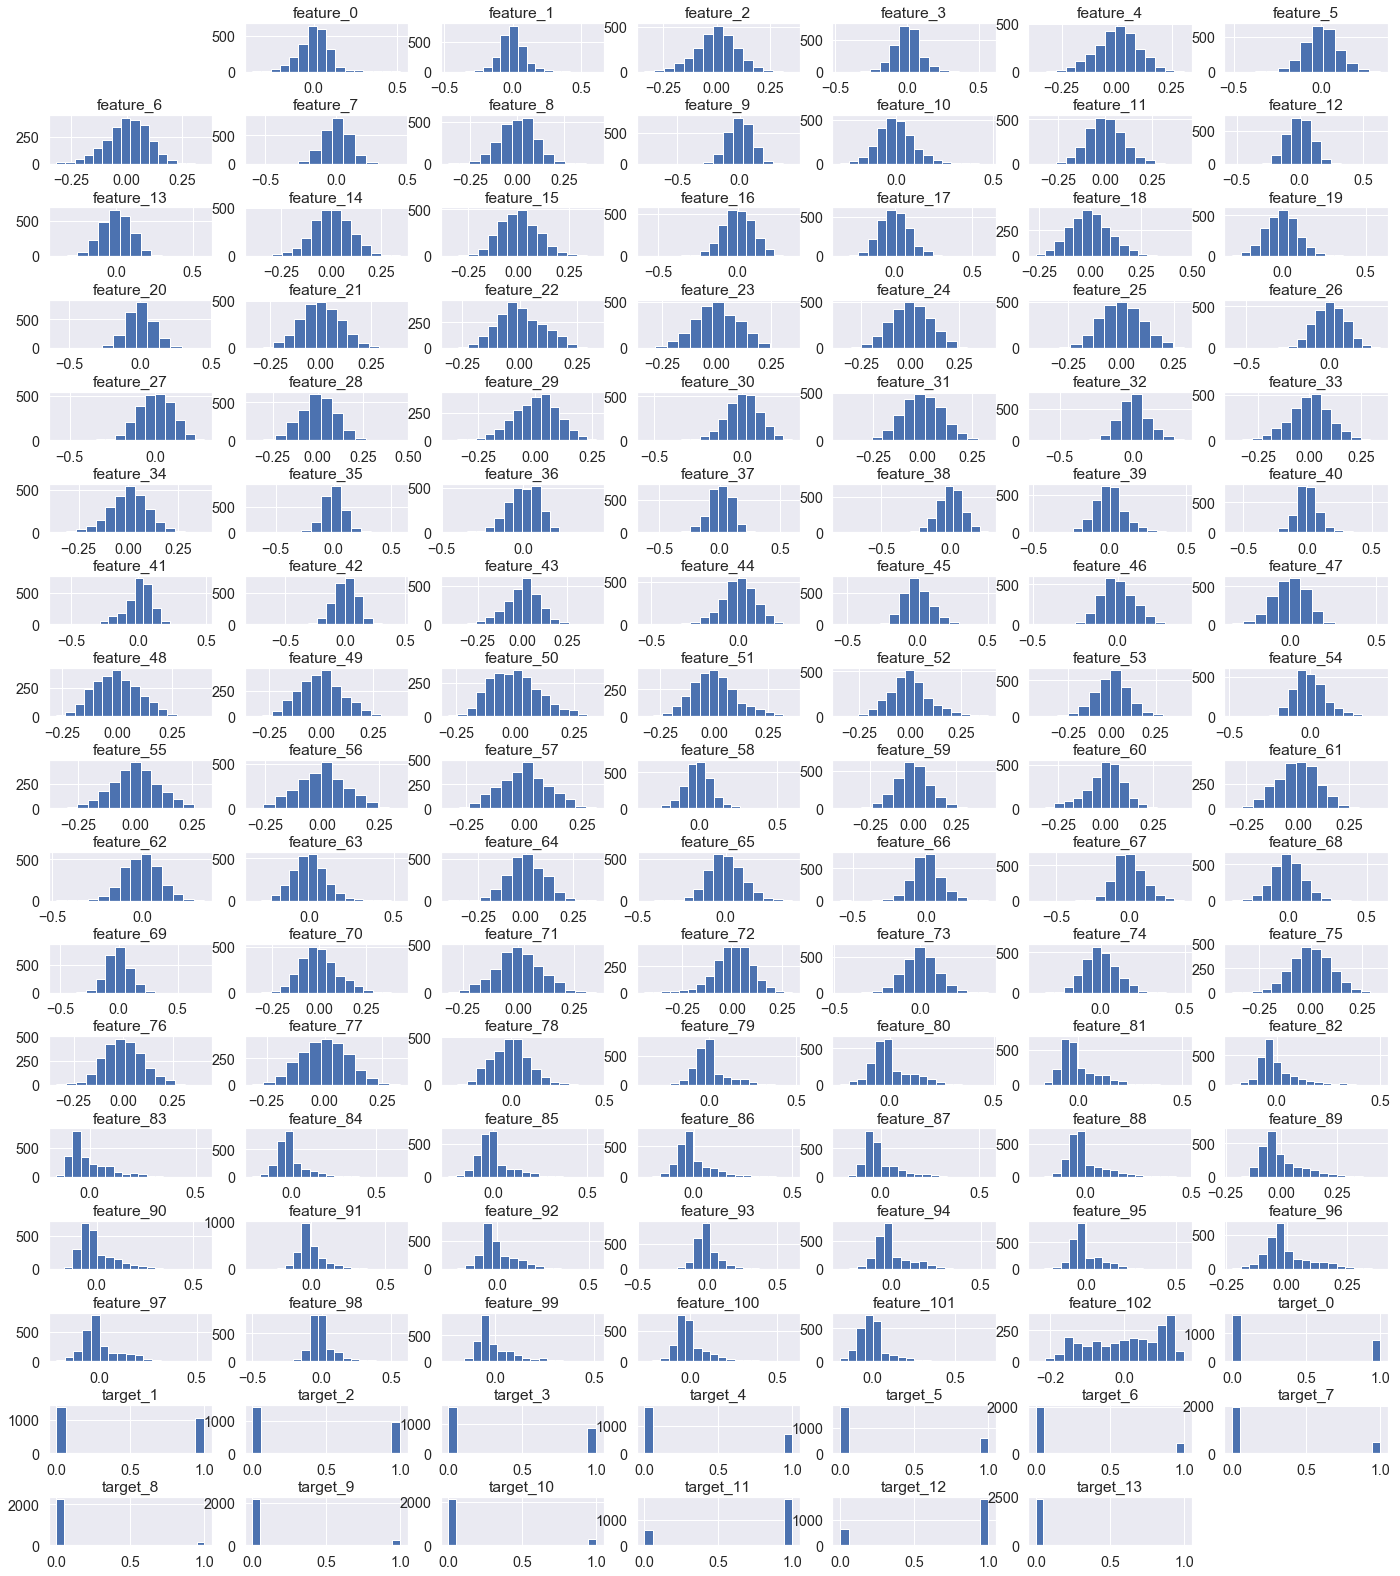

In [16]:
plt.figure(figsize=(24, 28))
for i, col in enumerate(df.columns):
    plt.subplot(17,7,i+2)
    plt.hist(df[col],bins='doane')
    plt.subplots_adjust(hspace = 0.9)
    plt.title(col);

- Separate target from whole dataset.

In [17]:
y = df.iloc[:,-14:]

In [18]:
for i, col in enumerate(y.columns[:-1]):
    print(y[col].value_counts())

0    1655
1     762
Name: target_0, dtype: int64
0    1379
1    1038
Name: target_1, dtype: int64
0    1434
1     983
Name: target_2, dtype: int64
0    1555
1     862
Name: target_3, dtype: int64
0    1695
1     722
Name: target_4, dtype: int64
0    1820
1     597
Name: target_5, dtype: int64
0    1989
1     428
Name: target_6, dtype: int64
0    1937
1     480
Name: target_7, dtype: int64
0    2239
1     178
Name: target_8, dtype: int64
0    2164
1     253
Name: target_9, dtype: int64
0    2128
1     289
Name: target_10, dtype: int64
1    1816
0     601
Name: target_11, dtype: int64
1    1799
0     618
Name: target_12, dtype: int64


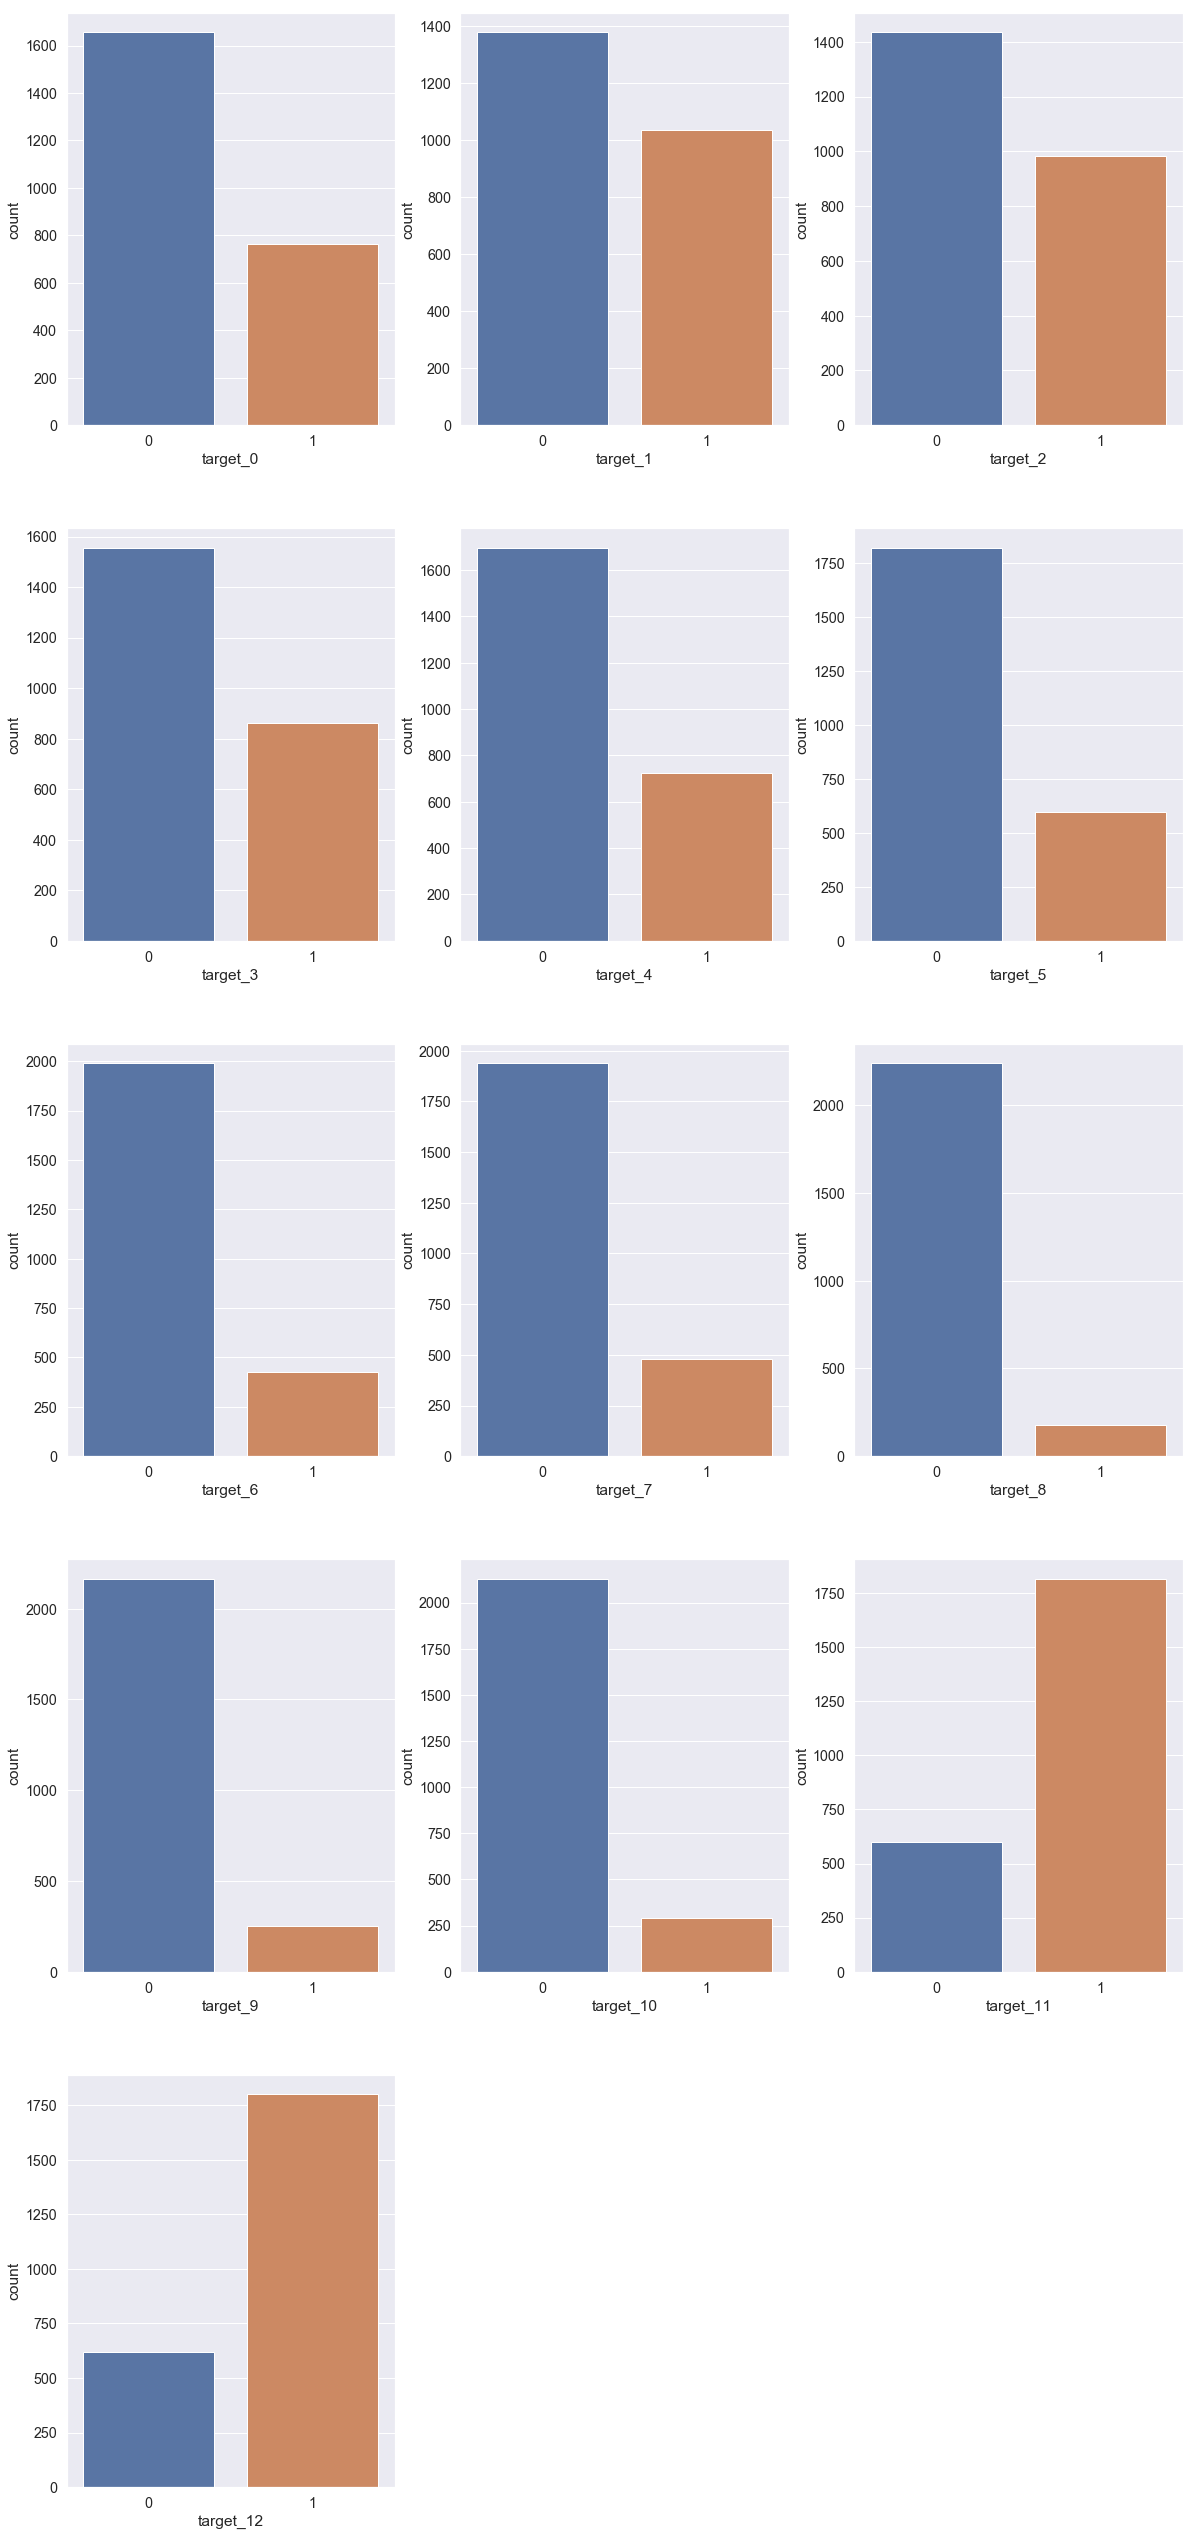

In [19]:
plt.figure(figsize=(20, 55)) 
for i, col in enumerate(y.columns[:-1]):# выводим все величины, кроме последней (целевой, ее будем рассматривать отдельно)
    plt.subplot(6,3,i+1)
    sns.countplot(x=y[col], data=y)
    plt.subplots_adjust(hspace = 0.25)

train/test split

In [20]:
columns_to_drop = df.columns
result = [k for k in columns_to_drop if 'target' in k]

In [21]:
df.drop(result, axis = 1, inplace = True)

Pay attention to shuffle = True

In [22]:
x_train, x_test, y_train, y_test = train_test_split(df, y, random_state = seed, test_size=0.3, shuffle=True)

In [23]:
x_train.shape

(1691, 103)

In [24]:
x_test.shape

(726, 103)

In [25]:
y_train.shape

(1691, 14)

In [26]:
y_test.shape

(726, 14)

Baseline with cross-validation and hyperparameters search.

In [27]:
skv = KFold(n_splits = 5,random_state=seed, shuffle=True)

In [28]:
params = {
    'multi_class' : 'multinomial',
    'solver' : 'newton-cg',
    'random_state' : seed, 
    'max_iter' : 10e3,
    'penalty' : 'l2',
    'class_weight' : 'balanced'  
    
}

In [29]:
def create_estimator(estimator):
    return estimator

In [30]:
'''results_list = []
for train, test in skv.split(df,y):
    #print("%s %s" % (train.shape, test.shape))   
    X_val, y_val = df.iloc[train], y.iloc[train]
    x_train, x_test, y_train, y_test = train_test_split(X_val, y_val, random_state = seed, test_size=0.3, shuffle=True)
    
    clf_log = create_estimator(OneVsRestClassifier(LogisticRegression(**params), n_jobs = -1))
    #clf_log.fit(x_train,y_train)
    
    skv_gs = KFold(n_splits = 3,random_state=seed, shuffle=True)
    my_scorer = make_scorer(f1_score, average='micro')
    tuned_parameters = [{
        'estimator__C': [0.01, 0.05, 0.1, 0.5, 0.7, 0.9, 1, 1.5, 5, 10, 20]
                    }]
    bclf = GridSearchCV(clf_log, tuned_parameters,
                        scoring=my_scorer, cv=skv, verbose=8, n_jobs=-1,refit='f1_score')

    bclf.fit(x_train, y_train)
    #clf_log.estimator.C = (bclf.best_params_['estimator__C'])
    #Call predict on the estimator with the best found parameters.
    y_pred_train = bclf.predict(x_train)
    y_pred_test = bclf.predict(x_test)
    f1_train = f1_score(y_train,y_pred_train,average='micro')
    f1_test = f1_score(y_test,y_pred_test,average='micro')
    results_list.append([f1_train , f1_test, bclf.best_params_]) 

results_list '''   

'results_list = []\nfor train, test in skv.split(df,y):\n    #print("%s %s" % (train.shape, test.shape))   \n    X_val, y_val = df.iloc[train], y.iloc[train]\n    x_train, x_test, y_train, y_test = train_test_split(X_val, y_val, random_state = seed, test_size=0.3, shuffle=True)\n    \n    clf_log = create_estimator(OneVsRestClassifier(LogisticRegression(**params), n_jobs = -1))\n    #clf_log.fit(x_train,y_train)\n    \n    skv_gs = KFold(n_splits = 3,random_state=seed, shuffle=True)\n    my_scorer = make_scorer(f1_score, average=\'micro\')\n    tuned_parameters = [{\n        \'estimator__C\': [0.01, 0.05, 0.1, 0.5, 0.7, 0.9, 1, 1.5, 5, 10, 20]\n                    }]\n    bclf = GridSearchCV(clf_log, tuned_parameters,\n                        scoring=my_scorer, cv=skv, verbose=8, n_jobs=-1,refit=\'f1_score\')\n\n    bclf.fit(x_train, y_train)\n    #clf_log.estimator.C = (bclf.best_params_[\'estimator__C\'])\n    #Call predict on the estimator with the best found parameters.\n    y_pred

In [32]:
def create_cv_plot(estimator):
    alphas = estimator.cv_results_['param_estimator__C'].data
    scores = estimator.cv_results_['mean_test_score']
    combined = pd.DataFrame({'alpha':alphas, 'score':scores})
    plt.figure(figsize=(18, 10))

    plt.plot(combined.alpha[0:20], combined.score[0:20],'go-')
    plt.grid(True)
    plt.title('C and metrics plot')
    plt.xlabel('C values') 
    plt.ylabel('F1 micro error')

#create_cv_plot(bclf)

NameError: name 'bclf' is not defined

Multilabel columns in outside?
LinearSVC
Check multilabel splits

Tensorflow.

In [33]:
#from tensorflow.examples.tutorials.mnist import input_data
tf.logging.set_verbosity(tf.logging.ERROR)
tf.reset_default_graph()

# Define paramaters for the model
learning_rate = 0.01
batch_size = 32
n_epochs = 5

In [ ]:
# Step 1: Read in data
# using TF Learn's built in function to load MNIST data to the folder data/mnist
#mnist = input_data.read_data_sets('data/mnist', one_hot=True)
#X_batch, Y_batch = mnist.train.next_batch(batch_size)

In [ ]:
# Step 2: create placeholders for features and labels
X = tf.placeholder(tf.float32, [batch_size, 103], name='feature_data') # 1x103 is a number of features, 0-102
Y = tf.placeholder(tf.float32, [batch_size, 14], name='label') # 1x14 is a number of unique labels, 0-13, int 32

In [ ]:
# Step 3: create weights and bias
# w is initialized to random variables with mean of 0, stddev of 0.01
# b is initialized to 0
# shape of w depends on the dimension of X and Y so that Y = tf.matmul(X, w)
# shape of b depends on Y
#w = tf.get_variable(name='weights', shape=(784, 10), initializer=tf.random_normal_initializer())
#b = tf.get_variable(name='bias', shape=(1, 10), initializer=tf.zeros_initializer())
w = tf.get_variable(name='weights', shape=(103, 14), initializer=tf.random_normal_initializer())
b = tf.get_variable(name='bias', shape=(1, 14), initializer=tf.zeros_initializer())

In [ ]:
# Step 4: build model
# the model that returns the logits.
# this logits will be later passed through softmax layer
logits_1 = tf.matmul(X, w) + b 

#logits_1 = tf.nn.softmax(tf.matmul(X, w) + b)
#logits_1 = tf.nn.sigmoid(tf.matmul(X, w) + b)

In [ ]:
# Step 5: define loss function
# use cross entropy of softmax of logits as the loss function
#entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y, name='loss') backup
#loss = tf.reduce_mean(entropy) # computes the mean over all the examples in the batch backup

entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_1, labels=Y, name='loss')

loss = tf.reduce_mean(entropy) # computes the mean over all the examples in the batch backup

#loss = tf.reduce_mean(-tf.reduce_sum(tf.nn.softmax(logits) * tf.log(Y), reduction_indices=[1]))

In [ ]:
# Step 6: define training op
# using gradient descent with learning rate of 0.01 to minimize loss
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [ ]:
def next_batch(num, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = data.iloc[idx]
    labels_shuffle = [labels.iloc[i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [ ]:
    y_p = tf.argmax(preds, 1)
    val_accuracy, y_pred = sess.run([accuracy, y_p], feed_dict={x:test_arrays, y:test_label})

    print "validation accuracy:", val_accuracy
    y_true = np.argmax(test_label,1)
    print "Precision", sk.metrics.precision_score(y_true, y_pred)
    print "Recall", sk.metrics.recall_score(y_true, y_pred)
    print "f1_score", sk.metrics.f1_score(y_true, y_pred)
    print "confusion_matrix"
    print sk.metrics.confusion_matrix(y_true, y_pred)
    fpr, tpr, tresholds = sk.metrics.roc_curve(y_true, y_pred)

In [ ]:
# Step 7: calculate accuracy with test set
#preds = tf.nn.softmax(logits_1)
preds = tf.round(tf.nn.sigmoid(logits_1))
correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))
#accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    n_batches = int(x_train.shape[0]/batch_size)
    
    # train the model n_epochs times
    for i in range(n_epochs): 
        total_loss = 0

        for j in range(n_batches):
            X_batch, Y_batch = next_batch(batch_size, x_train, y_train)
            _, loss_batch = sess.run([optimizer, loss], {X: X_batch, Y:Y_batch}) 
            total_loss += loss_batch
        print('Average loss epoch {0}: {1}'.format(i, total_loss/n_batches))

    # test the model
    n_batches = int(x_test.shape[0]/batch_size)
    total_correct_preds = 0

    for i in range(n_batches):
        X_batch, Y_batch = next_batch(batch_size, x_test, y_test)

        accuracy_batch = sess.run(accuracy, {X: X_batch, Y:Y_batch})
        total_correct_preds += accuracy_batch    
    
    print('Accuracy {0}'.format(total_correct_preds/x_test.shape[0]))
    '''y_p = tf.argmax(preds, 1)
    val_accuracy, y_pred = sess.run([accuracy, y_p], feed_dict={X:x_test, Y:y_test})
    
    
    print ("validation accuracy:", val_accuracy)
    y_true = np.argmax(Y_batch,1)
    #print ("Precision", sk.metrics.precision_score(y_true, y_pred))
    #print "Recall", sk.metrics.recall_score(y_true, y_pred)
    print ("f1_score", f1_score(y_true, y_pred,average='micro'))
    #print ("confusion_matrix")
    #print (confusion_matrix(y_true, y_pred))
    #fpr, tpr, tresholds = sk.metrics.roc_curve(y_true, y_pred)''';

Keras

In [42]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import binary_accuracy

In [43]:
x_train, x_test, y_train, y_test = train_test_split(df, y, random_state = seed, test_size=0.3, shuffle=True)

V1

In [60]:
model = Sequential()
output_dim = y_train.shape[1]

model.add(Dense(output_dim, activation='relu', input_shape=(103,)))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size, epochs=5,
          validation_data = (x_test, y_test))

Train on 1691 samples, validate on 726 samples
Epoch 1/5
1691/1691 [==============================] - ETA: 32s - loss: 2.9951 - acc: 0.70 - ETA: 0s - loss: 2.6423 - acc: 0.6990 - 1s 473us/step - loss: 2.5820 - acc: 0.6994 - val_loss: 2.4933 - val_acc: 0.6923
Epoch 2/5
1691/1691 [==============================] - ETA: 0s - loss: 2.0980 - acc: 0.754 - ETA: 0s - loss: 2.3068 - acc: 0.703 - 0s 61us/step - loss: 2.2749 - acc: 0.6994 - val_loss: 2.2826 - val_acc: 0.6924
Epoch 3/5
1691/1691 [==============================] - ETA: 0s - loss: 1.9859 - acc: 0.700 - ETA: 0s - loss: 2.0609 - acc: 0.701 - 0s 58us/step - loss: 2.0716 - acc: 0.6995 - val_loss: 2.0804 - val_acc: 0.6924
Epoch 4/5
1691/1691 [==============================] - ETA: 0s - loss: 1.7381 - acc: 0.705 - ETA: 0s - loss: 1.9107 - acc: 0.701 - 0s 54us/step - loss: 1.8955 - acc: 0.6995 - val_loss: 1.8697 - val_acc: 0.6923
Epoch 5/5
1691/1691 [==============================] - ETA: 0s - loss: 2.2181 - acc: 0.705 - ETA: 0s - loss: 1.

V2

In [56]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(103,)))
model.add(Dense(output_dim = y_train.shape[1], activation='sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size, epochs=5,
          validation_data = (x_test, y_test))

Train on 1691 samples, validate on 726 samples
Epoch 1/5
1691/1691 [==============================] - ETA: 33s - loss: 0.6989 - acc: 0.43 - ETA: 0s - loss: 0.6605 - acc: 0.6927 - 1s 485us/step - loss: 0.6435 - acc: 0.7158 - val_loss: 0.5831 - val_acc: 0.7686
Epoch 2/5
1691/1691 [==============================] - ETA: 0s - loss: 0.5867 - acc: 0.767 - ETA: 0s - loss: 0.5519 - acc: 0.775 - ETA: 0s - loss: 0.5276 - acc: 0.778 - 0s 81us/step - loss: 0.5264 - acc: 0.7783 - val_loss: 0.4920 - val_acc: 0.7774
Epoch 3/5
1691/1691 [==============================] - ETA: 0s - loss: 0.4785 - acc: 0.787 - ETA: 0s - loss: 0.4703 - acc: 0.790 - ETA: 0s - loss: 0.4673 - acc: 0.790 - 0s 78us/step - loss: 0.4680 - acc: 0.7897 - val_loss: 0.4681 - val_acc: 0.7887
Epoch 4/5
1691/1691 [==============================] - ETA: 0s - loss: 0.4533 - acc: 0.801 - ETA: 0s - loss: 0.4557 - acc: 0.794 - 0s 71us/step - loss: 0.4505 - acc: 0.7986 - val_loss: 0.4590 - val_acc: 0.7920
Epoch 5/5
1691/1691 [==============

In [ ]:
#y_test = mnist.test.labels.argmax(axis=1)

y_predicted_scores = model.predict(x_test)
y_predicted = y_predicted_scores.argmax(axis=1)

#print('Classification report\n')
#print(classification_report(y_test, y_predicted))

In [ ]:
from utils import print_confusion_matrix
print_confusion_matrix(confusion_matrix(y_test, y_predicted), range(0, 14))
plt.show()

In [ ]:
# show incorrect predictions

from itertools import islice

incorrect_classified = y_test != y_predicted
incorrect_classified_scores = y_predicted_scores[incorrect_classified]
incorrect_classified_scores_sorted_idx = incorrect_classified_scores.max(axis=1).argsort()[::-1]
incorrect_classified_scores = incorrect_classified_scores[incorrect_classified_scores_sorted_idx]

incorrect_classified_images = mnist.test.images[incorrect_classified][incorrect_classified_scores_sorted_idx]
incorrect_classified_gt = y_test[incorrect_classified][incorrect_classified_scores_sorted_idx]


top_n_examples = 5
iter_incorrect = islice(zip(incorrect_classified_images,
                            incorrect_classified_gt,
                            incorrect_classified_scores),
                        top_n_examples)

for im, label, score in iter_incorrect:
    print('Correct label:', label)
    predicted_label = score.argmax()
    print('Predicted:', predicted_label, 'with score', score[predicted_label])
    plt.imshow(im.reshape((28, 28)), 'gray')
    plt.show()